In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from xgboost import plot_importance

from functions.Pre_processing_Casos_Graves import *
from functions.Pre_processing_models import *

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection._split import StratifiedKFold


from sklearn.inspection import permutation_importance
from imblearn.over_sampling import RandomOverSampler 


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, SelectFdr

#### Lendo o dataset:

In [2]:
df = pd.read_csv('..\Data\Casos Graves\df_casos_graves')

#### Utilizando a class de pré-processamento para preparar o dataset:

In [3]:
list_features = ["SYMPTOM_COUGH",'SYMPTOM_COLD','SYMPTOM_AIR_INSUFFICIENCY','SYMPTOM_FEVER','SYMPTOM_LOW_OXYGEN_SATURATION','SYMPTOM_BREATHING_CONDITION','SYMPTOM_TORACIC_APERTURE','SYMPTOM_THROAT_CONDITION',
                'SYMPTOM_HEADACHE','SYMPTOM_BODY_PAIN','SYMPTOM_DIARRHEA','SYMPTOM_RUNNY_NOSE','SYMPTOM_NOSE_CONGESTION','SYMPTOM_WEAKNESS','SYMPTOM_ANOSMIA_OR_HYPOSMIA','SYMPTOM_NAUSEA','SYMPTOM_LACK_OF_APPETITE',
                'SYMPTOM_ABDOMINAL_PAIN','SYMPTOM_CONSCIOUSNESS_DEGRADATION','DISEASE_HEART_OR_VASCULAR','DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY','DISEASE_KIDNEY','DISEASE_IMMUNOSUPPRESSION',
                'DISEASE_TABAGIST','DISEASE_ETILISM','DISEASE_LIVER','DISEASE_NEUROLOGIC','death', 'idade', 'sexo_Feminino','sexo_Masculino', 'data_notificacao']

In [4]:
Pre_processing_models_df = Pre_processing_models(df)
Pre_processing_models_df.run_graves()

df = Pre_processing_models_df.df
df = df[list_features]
df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])
df = df.sort_values(by='data_notificacao', ascending=True)
df = df.reset_index()
df = df.drop("index", axis=1)
df

C:\Users\maril\AppData\Local\Temp\ipykernel_39172\3432879523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.356522,0,1,2020-02-26
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-26
2,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.217391,1,0,2020-02-27
3,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-27
4,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.260870,1,0,2020-02-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36430,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2022-06-12
36431,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.556522,0,1,2022-06-12
36432,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.573913,1,0,2022-06-12
36433,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2022-06-13


### Criação de uma função para configuração do modelo:

In [5]:
import xgboost as xgb

def instantiate_XGBoost_model (X_train, y_train):
    param_grid = {
        "max_depth": [3, 5, 7],
        #"learning_rate": [0.1, 0.2],
        "gamma": [0.25, 1],
        #"reg_lambda": [0, 1, 10],
        "scale_pos_weight": [1, 3, 5],
        #"subsample": [0.8],
        "colsample_bytree": [0.5, 0.9] }

    # Init classifier
    xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 1)

    # Init Grid Search
    grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs = -1, cv=5, scoring = "roc_auc")

    # Fit 
    _ = grid_cv.fit(X_train, y_train)

    mean_test_score = grid_cv.cv_results_['mean_test_score'].mean()
    std_test_score = grid_cv.cv_results_['std_test_score'].mean()
    best_score = grid_cv.best_score_
    best_params = grid_cv.best_params_

    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score']}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score']}")
    #print('')

    print('#'*40)
    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score'].mean()}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score'].mean()}")
    print('')
    print(f'best_score: {grid_cv.best_score_}')
    print(f'best_params_: {grid_cv.best_params_}')
    print('#'*40)
    print('')

    return mean_test_score, std_test_score, best_score, best_params

### Criação de uma função para aplicação do modelo:

In [6]:
def apply_model_xgboost(df):
    list_random_states = [42]

    mean_test_scores = []
    std_test_scores = []
    best_scores = []
    best_params = []

    #treino!
    data_inicio = df['data_notificacao'][0]
    data_fim = df['data_notificacao'][0]+pd.Timedelta(days=45)
    
    treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim )]
    X_train = treino.drop(labels=['death', 'data_notificacao'], axis=1)
    y_train = treino['death']

    #teste!
    teste = df[(df['data_notificacao'] > data_fim)]
    X_test = teste.drop(labels=['death', 'data_notificacao'], axis=1)
    y_test = teste['death']

    oversample = RandomOverSampler(sampling_strategy='minority')
    X_over, y_over = oversample.fit_resample(X_train, y_train)


    for random_state in list_random_states:

        mean_test_score, std_test_score, best_score, best_param = instantiate_XGBoost_model(X_over, y_over)

        mean_test_scores.append(mean_test_score)
        std_test_scores.append(std_test_score)
        best_scores.append(best_score)
        best_params.append(best_param)

    return (X_over, y_over, X_test, y_test, mean_test_scores, std_test_scores, best_scores, best_params)

### Criação de uma função para imprimir as métricas do classificador final de cada modelo:

In [7]:
import xgboost as xgb

def create_final_cl(X_over, y_over, X_test, y_test, colsample_bytree, gamma, max_depth, scale_pos_weight):

    # parametrizando o modelo final
    final_cl = xgb.XGBClassifier(colsample_bytree = colsample_bytree, gamma = gamma, max_depth = max_depth, scale_pos_weight = scale_pos_weight)
    #treinando o modelo final
    final_cl.fit(X_over, y_over)
    preds = final_cl.predict(X_test)
    accuracy_score(y_test, preds)

    print('accuracy_score:', accuracy_score(y_test, preds))
    print('#'*40)

    print('"""Métricas f1_score:"""')
    print('f1: ', f1_score(y_test, preds))
    print('Macro: ', f1_score(y_test, preds, average='macro'))
    print('Micro: ', f1_score(y_test, preds, average='micro'))
    print('weighted: ', f1_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""Métricas precision_score:"""')
    print('Precision: ', precision_score(y_test, preds))
    print('Macro: ', precision_score(y_test, preds, average='macro'))
    print('Micro: ', precision_score(y_test, preds, average='micro'))
    print('weighted: ', precision_score(y_test, preds, average='weighted'))

    return preds, final_cl

### Criação de funções para gerar a matriz de confusão e classification report:

In [8]:
def plot_conf_matrix (X_test, y_test, preds, final_cl):

    confusion_matrix(y_test, preds)
    matrix = plot_confusion_matrix(final_cl, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()
    print(classification_report(y_test, preds))


def plot_roc_curve(y_test, preds):
    
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

### Teste com o Período 1 (26/02/2020 até 25/05/2020):

In [9]:
#Periodo 1
data_inicio = df['data_notificacao'][0]
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=90)

df_1 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim)]
df_1

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.356522,0,1,2020-02-26
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-26
2,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.217391,1,0,2020-02-27
3,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-27
4,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.260870,1,0,2020-02-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.400000,0,1,2020-05-25
10819,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.626087,0,1,2020-05-25
10820,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.704348,1,0,2020-05-25
10821,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0.782609,0,1,2020-05-25


In [10]:
rslt_df = df_1[df_1['death'] == 1]
rslt_df

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
47,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.591304,0,1,2020-03-12
387,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.739130,0,1,2020-03-20
391,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.565217,0,1,2020-03-20
403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.686957,1,0,2020-03-20
415,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.756522,1,0,2020-03-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10816,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.765217,1,0,2020-05-25
10817,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.721739,1,0,2020-05-25
10818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.400000,0,1,2020-05-25
10819,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.626087,0,1,2020-05-25


In [12]:
rslt_df2 = rslt_df[rslt_df['sexo_Feminino'] == 1]
rslt_df2

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.686957,1,0,2020-03-20
415,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.756522,1,0,2020-03-21
458,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.591304,1,0,2020-03-23
473,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.600000,1,0,2020-03-23
487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.669565,1,0,2020-03-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10794,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.478261,1,0,2020-05-25
10805,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0.565217,1,0,2020-05-25
10808,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.721739,1,0,2020-05-25
10816,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.765217,1,0,2020-05-25


In [13]:
rslt_df3 = rslt_df[rslt_df['SYMPTOM_AIR_INSUFFICIENCY'] == 1]
rslt_df3

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
391,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.565217,0,1,2020-03-20
440,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.600000,0,1,2020-03-22
458,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.591304,1,0,2020-03-23
473,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.600000,1,0,2020-03-23
478,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.643478,0,1,2020-03-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10812,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.504348,0,1,2020-05-25
10815,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.652174,0,1,2020-05-25
10817,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.721739,1,0,2020-05-25
10819,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.626087,0,1,2020-05-25


In [10]:
X_train_oversampled_1, y_train_oversampled_1, X_test_1, y_test_1, mean_test_scores_1, std_test_scores_1, best_scores_1, best_params_1 = apply_model_xgboost(df_1)

########################################

best_score: 0.9581135546914468
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################



In [11]:
preds_1, final_cl_1 = create_final_cl(X_train_oversampled_1, y_train_oversampled_1, X_test_1, y_test_1, 0.9, 0.25, 7, 3)

accuracy_score: 0.747215777262181
########################################
"""Métricas f1_score:"""
f1:  0.5604196086342547
Macro:  0.6915099752851319
Micro:  0.747215777262181
weighted:  0.7623474379138774
########################################
"""Métricas precision_score:"""
Precision:  0.46673387096774194
Macro:  0.6809218610685627
Micro:  0.747215777262181
weighted:  0.7966628886659667


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


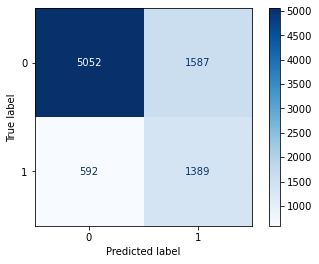

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      6639
           1       0.47      0.70      0.56      1981

    accuracy                           0.75      8620
   macro avg       0.68      0.73      0.69      8620
weighted avg       0.80      0.75      0.76      8620

roc_auc_score:  0.7310595026908364


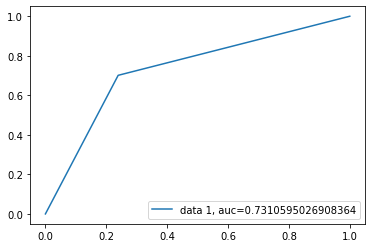

In [12]:
plot_conf_matrix (X_test_1, y_test_1, preds_1, final_cl_1)

plot_roc_curve(y_test_1, preds_1)

### Definição dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

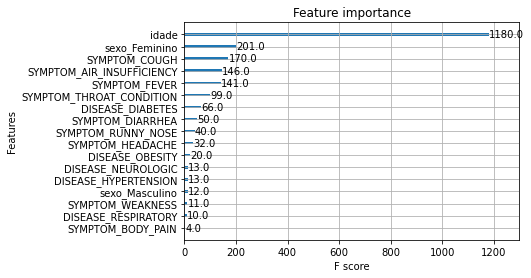

In [33]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_1)
plt.show()

### Teste com o Período 2 (27/03/2020 até 24/06/2020):

In [14]:
#Periodo 2
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=30)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=120)

df_2 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_2 = df_2.reset_index()
df_2 = df_2.drop("index", axis=1)
df_2

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.730435,1,0,2020-03-27
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.600000,0,1,2020-03-27
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.504348,0,1,2020-03-27
3,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.278261,1,0,2020-03-27
4,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.286957,1,0,2020-03-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12581,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.356522,1,0,2020-06-24
12582,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.095652,1,0,2020-06-24
12583,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.226087,1,0,2020-06-24
12584,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.313043,0,1,2020-06-24


In [15]:
X_train_oversampled_2, y_train_oversampled_2, X_test_2, y_test_2, mean_test_scores_2, std_test_scores_2, best_scores_2, best_params_2 = apply_model_xgboost(df_2)

########################################

best_score: 0.9338738300964378
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################



In [16]:
preds_2, final_cl_2 = create_final_cl(X_train_oversampled_2, y_train_oversampled_2, X_test_2, y_test_2, 0.9, 0.25, 7, 3)

accuracy_score: 0.604236577181208
########################################
"""Métricas f1_score:"""
f1:  0.5462851647030537
Macro:  0.5976729896418375
Micro:  0.604236577181208
weighted:  0.621168261950258
########################################
"""Métricas precision_score:"""
Precision:  0.39650959860383944
Macro:  0.6567413994070169
Micro:  0.604236577181208
weighted:  0.7757232210829664


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


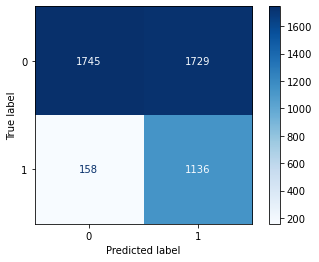

              precision    recall  f1-score   support

           0       0.92      0.50      0.65      3474
           1       0.40      0.88      0.55      1294

    accuracy                           0.60      4768
   macro avg       0.66      0.69      0.60      4768
weighted avg       0.78      0.60      0.62      4768

roc_auc_score:  0.6901004058410503


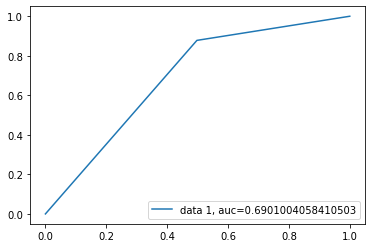

In [17]:
plot_conf_matrix (X_test_2, y_test_2, preds_2, final_cl_2)

plot_roc_curve(y_test_2, preds_2)

### Definição dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

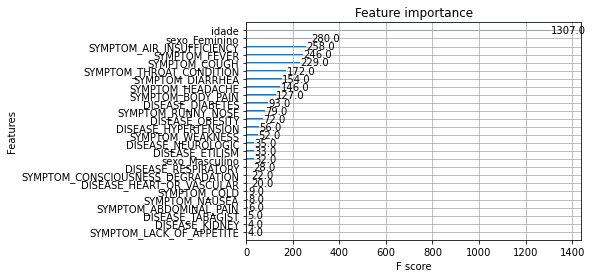

In [34]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_2)
plt.show()

### Teste com o Período 3 (26/04/2020 até 24/07/2020):

In [19]:
#Periodo 3
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=60)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=150)

df_3 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_3 = df_3.reset_index()
df_3 = df_3.drop("index", axis=1)
df_3

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.652174,0,1,2020-04-26
1,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.443478,0,1,2020-04-26
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.782609,1,0,2020-04-26
3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.747826,1,0,2020-04-26
4,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.452174,1,0,2020-04-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9580,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.026087,0,1,2020-07-24
9581,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.834783,1,0,2020-07-24
9582,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.486957,0,1,2020-07-24
9583,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0.339130,1,0,2020-07-24


In [20]:
X_train_oversampled_3, y_train_oversampled_3, X_test_3, y_test_3, mean_test_scores_3, std_test_scores_3, best_scores_3, best_params_3 = apply_model_xgboost(df_3)

########################################

best_score: 0.872233997795058
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [21]:
preds_3, final_cl_3 = create_final_cl(X_train_oversampled_3, y_train_oversampled_3, X_test_3, y_test_3, 0.9, 0.25, 7, 5)

accuracy_score: 0.5654450261780105
########################################
"""Métricas f1_score:"""
f1:  0.4629168740666998
Macro:  0.5490100095730861
Micro:  0.5654450261780105
weighted:  0.5983497324186712
########################################
"""Métricas precision_score:"""
Precision:  0.3144016227180527
Macro:  0.6248302934307395
Micro:  0.5654450261780105
weighted:  0.8027360519583888


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


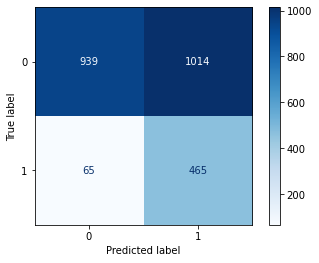

              precision    recall  f1-score   support

           0       0.94      0.48      0.64      1953
           1       0.31      0.88      0.46       530

    accuracy                           0.57      2483
   macro avg       0.62      0.68      0.55      2483
weighted avg       0.80      0.57      0.60      2483

roc_auc_score:  0.6790786308436947


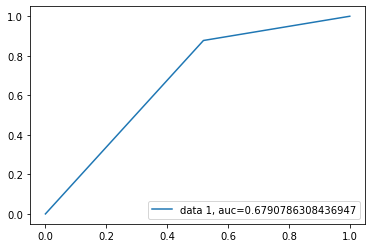

In [22]:
plot_conf_matrix (X_test_3, y_test_3, preds_3, final_cl_3)

plot_roc_curve(y_test_3, preds_3)

### Definição dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

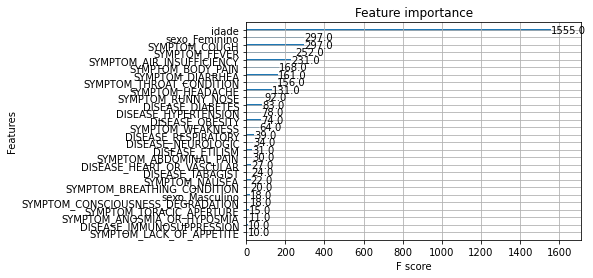

In [35]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_3)
plt.show()

### Teste com o Período 4 (26/05/2020 até 23/08/2020):

In [36]:
#Periodo 4
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=90)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=180)

df_4 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_4 = df_4.reset_index()
df_4 = df_4.drop("index", axis=1)
df_4

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.347826,0,1,2020-05-26
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.695652,0,1,2020-05-26
2,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0.565217,1,0,2020-05-26
3,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.200000,1,0,2020-05-26
4,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.426087,0,1,2020-05-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2020-08-23
5302,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.417391,0,1,2020-08-23
5303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.521739,1,0,2020-08-23
5304,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.095652,0,1,2020-08-23


In [37]:
X_train_oversampled_4, y_train_oversampled_4, X_test_4, y_test_4, mean_test_scores_4, std_test_scores_4, best_scores_4, best_params_4 = apply_model_xgboost(df_4)

########################################

best_score: 0.8642158927756549
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [38]:
preds_4, final_cl_4 = create_final_cl(X_train_oversampled_4, y_train_oversampled_4, X_test_4, y_test_4, 0.9, 0.25, 7, 5)

accuracy_score: 0.6180257510729614
########################################
"""Métricas f1_score:"""
f1:  0.44025157232704404
Macro:  0.5751746460983754
Micro:  0.6180257510729614
weighted:  0.659139649089118
########################################
"""Métricas precision_score:"""
Precision:  0.30434782608695654
Macro:  0.6140383198231393
Micro:  0.6180257510729614
weighted:  0.8067641635645406


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


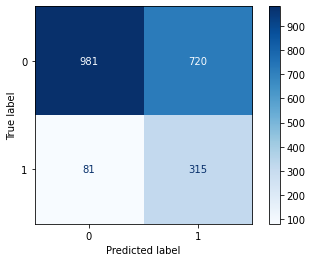

              precision    recall  f1-score   support

           0       0.92      0.58      0.71      1701
           1       0.30      0.80      0.44       396

    accuracy                           0.62      2097
   macro avg       0.61      0.69      0.58      2097
weighted avg       0.81      0.62      0.66      2097

roc_auc_score:  0.6860870610870611


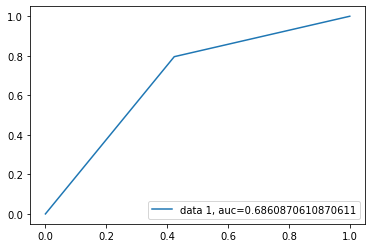

In [39]:
plot_conf_matrix (X_test_4, y_test_4, preds_4, final_cl_4)

plot_roc_curve(y_test_4, preds_4)

### Definição dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

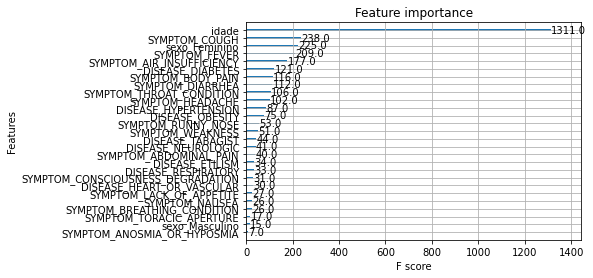

In [40]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_4)
plt.show()

### Teste com o Período 5 (25/06/2020 até 22/09/2020):

In [41]:
#Periodo 5
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=120)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=210)

df_5 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_5 = df_5.reset_index()
df_5 = df_5.drop("index", axis=1)
df_5

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.330435,1,0,2020-06-25
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.026087,0,1,2020-06-25
2,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.547826,1,0,2020-06-25
3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.008696,1,0,2020-06-25
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.304348,1,0,2020-06-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,1,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0.478261,0,1,2020-09-22
3795,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.660870,0,1,2020-09-22
3796,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.208696,0,1,2020-09-22
3797,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.573913,0,1,2020-09-22


In [42]:
X_train_oversampled_5, y_train_oversampled_5, X_test_5, y_test_5, mean_test_scores_5, std_test_scores_5, best_scores_5, best_params_5 = apply_model_xgboost(df_5)

########################################

best_score: 0.9205421172447832
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [43]:
preds_5, final_cl_5 = create_final_cl(X_train_oversampled_5, y_train_oversampled_5, X_test_5, y_test_5, 0.9, 0.25, 7, 5)

accuracy_score: 0.6542776998597476
########################################
"""Métricas f1_score:"""
f1:  0.4287369640787949
Macro:  0.5904368581077735
Micro:  0.6542776998597476
weighted:  0.6920379135425314
########################################
"""Métricas precision_score:"""
Precision:  0.3093645484949833
Macro:  0.6063730955035302
Micro:  0.6542776998597476
weighted:  0.7929927716042724


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


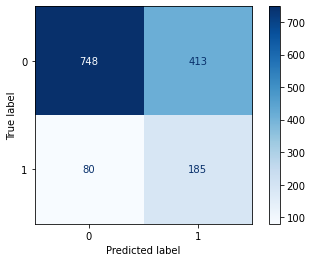

              precision    recall  f1-score   support

           0       0.90      0.64      0.75      1161
           1       0.31      0.70      0.43       265

    accuracy                           0.65      1426
   macro avg       0.61      0.67      0.59      1426
weighted avg       0.79      0.65      0.69      1426

roc_auc_score:  0.671192693351535


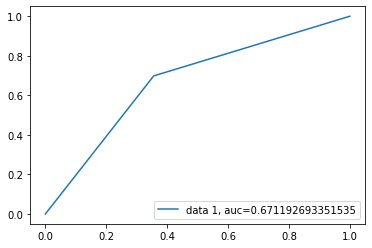

In [44]:
plot_conf_matrix (X_test_5, y_test_5, preds_5, final_cl_5)

plot_roc_curve(y_test_5, preds_5)

### Definição dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

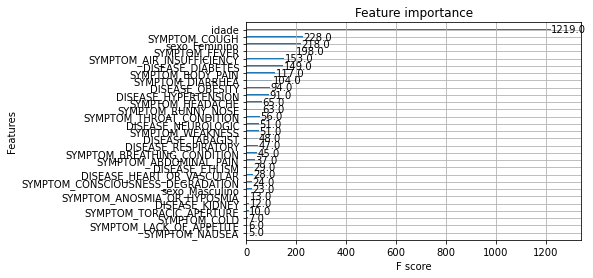

In [45]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_5)
plt.show()

### Teste com o Período 6 (25/07/2020 até 22/10/2020):

In [46]:
#Periodo 6
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=150)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=240)

df_6 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_6 = df_6.reset_index()
df_6 = df_6.drop("index", axis=1)
df_6

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.591304,0,1,2020-07-25
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.539130,1,0,2020-07-25
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.373913,1,0,2020-07-25
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.478261,1,0,2020-07-25
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.660870,1,0,2020-07-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2781,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.495652,1,0,2020-10-22
2782,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.747826,1,0,2020-10-22
2783,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.434783,0,1,2020-10-22
2784,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.608696,1,0,2020-10-22


In [47]:
X_train_oversampled_6, y_train_oversampled_6, X_test_6, y_test_6, mean_test_scores_6, std_test_scores_6, best_scores_6, best_params_6 = apply_model_xgboost(df_6)

########################################

best_score: 0.9390948937581868
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [48]:
preds_6, final_cl_6 = create_final_cl(X_train_oversampled_6, y_train_oversampled_6, X_test_6, y_test_6, 0.9, 0.25, 7, 5)

accuracy_score: 0.654158215010142
########################################
"""Métricas f1_score:"""
f1:  0.4473257698541329
Macro:  0.5978326266244834
Micro:  0.654158215010142
weighted:  0.6772074395256825
########################################
"""Métricas precision_score:"""
Precision:  0.359375
Macro:  0.6007838455149501
Micro:  0.654158215010142
weighted:  0.7280988553199949


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


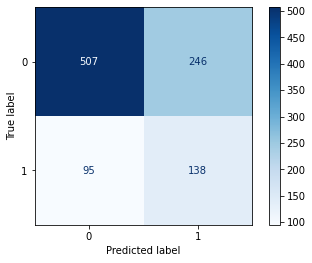

              precision    recall  f1-score   support

           0       0.84      0.67      0.75       753
           1       0.36      0.59      0.45       233

    accuracy                           0.65       986
   macro avg       0.60      0.63      0.60       986
weighted avg       0.73      0.65      0.68       986

roc_auc_score:  0.6327907255099773


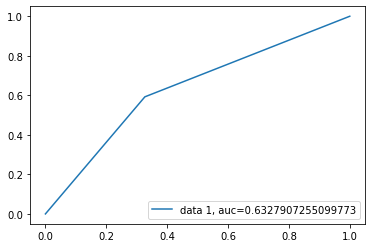

In [49]:
plot_conf_matrix (X_test_6, y_test_6, preds_6, final_cl_6)

plot_roc_curve(y_test_6, preds_6)

### Definição dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

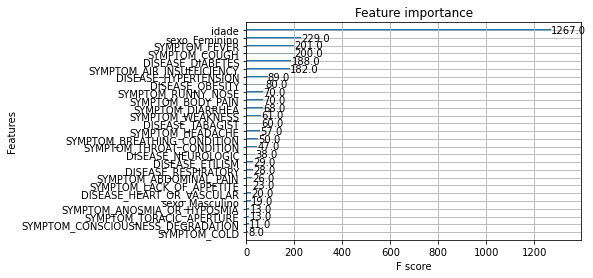

In [50]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_6)
plt.show()

### Teste com o Período 7 (24/08/2020 até 21/11/2020):

In [51]:
#Periodo 7
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=180)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=270)

df_7 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_7 = df_7.reset_index()
df_7 = df_7.drop("index", axis=1)
df_7

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.304348,0,1,2020-08-24
1,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0.217391,1,0,2020-08-24
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.678261,1,0,2020-08-24
3,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.017391,1,0,2020-08-24
4,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.678261,0,1,2020-08-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.486957,0,1,2020-11-21
2289,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.373913,1,0,2020-11-21
2290,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.313043,0,1,2020-11-21
2291,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.739130,0,1,2020-11-21


In [52]:
X_train_oversampled_7, y_train_oversampled_7, X_test_7, y_test_7, mean_test_scores_7, std_test_scores_7, best_scores_7, best_params_7 = apply_model_xgboost(df_7)

########################################

best_score: 0.9350344975704046
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [53]:
preds_7, final_cl_7 = create_final_cl(X_train_oversampled_7, y_train_oversampled_7, X_test_7, y_test_7, 0.9, 0.25, 7, 5)

accuracy_score: 0.6498599439775911
########################################
"""Métricas f1_score:"""
f1:  0.45255474452554745
Macro:  0.5975882850973654
Micro:  0.6498599439775911
weighted:  0.6586621663278882
########################################
"""Métricas precision_score:"""
Precision:  0.41333333333333333
Macro:  0.595316091954023
Micro:  0.6498599439775911
weighted:  0.6719493544544254


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


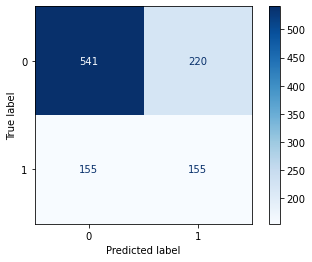

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       761
           1       0.41      0.50      0.45       310

    accuracy                           0.65      1071
   macro avg       0.60      0.61      0.60      1071
weighted avg       0.67      0.65      0.66      1071

roc_auc_score:  0.6054533508541393


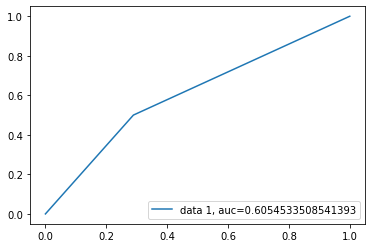

In [54]:
plot_conf_matrix (X_test_7, y_test_7, preds_7, final_cl_7)

plot_roc_curve(y_test_7, preds_7)

### Definição dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

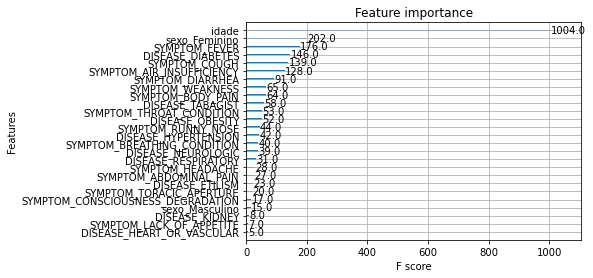

In [55]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_7)
plt.show()


### Teste com o Período 8 (23/09/2020 até 21/12/2020):

In [56]:
#Periodo 8
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=210)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=300)

df_8 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_8 = df_8.reset_index()
df_8 = df_8.drop("index", axis=1)
df_8

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2020-09-23
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.052174,0,1,2020-09-23
2,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0.339130,0,1,2020-09-23
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.539130,1,0,2020-09-23
4,1,0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0.486957,0,1,2020-09-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2356,1,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0.591304,0,1,2020-12-21
2357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.573913,0,1,2020-12-21
2358,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.739130,1,0,2020-12-21
2359,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0.504348,0,1,2020-12-21


In [57]:
X_train_oversampled_8, y_train_oversampled_8, X_test_8, y_test_8, mean_test_scores_8, std_test_scores_8, best_scores_8, best_params_8 = apply_model_xgboost(df_8)

########################################

best_score: 0.9029999173652827
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [58]:
preds_8, final_cl_8 = create_final_cl(X_train_oversampled_8, y_train_oversampled_8, X_test_8, y_test_8, 0.9, 0.25, 7, 5)

accuracy_score: 0.6419077404222049
########################################
"""Métricas f1_score:"""
f1:  0.5138004246284501
Macro:  0.6151922915221458
Micro:  0.6419077404222049
weighted:  0.6495180760139131
########################################
"""Métricas precision_score:"""
Precision:  0.4662813102119461
Macro:  0.614061707737552
Micro:  0.6419077404222049
weighted:  0.6640921316066586


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


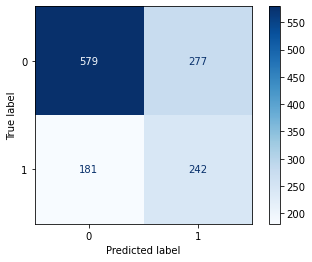

              precision    recall  f1-score   support

           0       0.76      0.68      0.72       856
           1       0.47      0.57      0.51       423

    accuracy                           0.64      1279
   macro avg       0.61      0.62      0.62      1279
weighted avg       0.66      0.64      0.65      1279

roc_auc_score:  0.6242529440357041


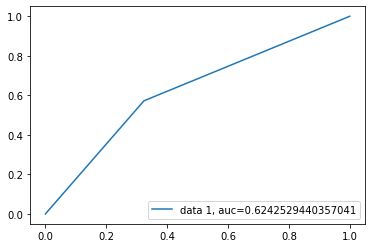

In [59]:
plot_conf_matrix (X_test_8, y_test_8, preds_8, final_cl_8)

plot_roc_curve(y_test_8, preds_8)

### Determinação dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

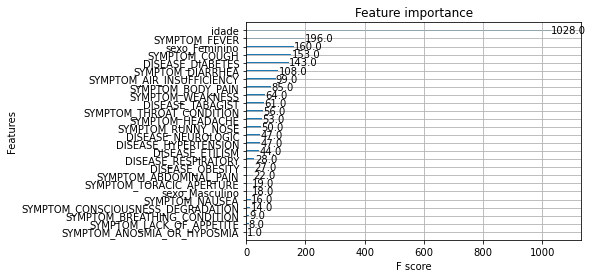

In [60]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_8)
plt.show()

### Teste com o Período 9 (23/10/2020 até 20/01/2021):

In [61]:
#Periodo 9
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=240)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=330)

df_9 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_9 = df_9.reset_index()
df_9 = df_9.drop("index", axis=1)
df_9

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.530435,1,0,2020-10-23
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2020-10-23
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.130435,1,0,2020-10-23
3,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.034783,0,1,2020-10-23
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.530435,0,1,2020-10-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2652,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.643478,0,1,2021-01-20
2653,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0.391304,1,0,2021-01-20
2654,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0.869565,0,1,2021-01-20
2655,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.634783,1,0,2021-01-20


In [62]:
X_train_oversampled_9, y_train_oversampled_9, X_test_9, y_test_9, mean_test_scores_9, std_test_scores_9, best_scores_9, best_params_9 = apply_model_xgboost(df_9)

########################################

best_score: 0.9031273061492842
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [63]:
preds_9, final_cl_9 = create_final_cl(X_train_oversampled_9, y_train_oversampled_9, X_test_9, y_test_9, 0.9, 0.25, 7, 5)

accuracy_score: 0.6278906797477225
########################################
"""Métricas f1_score:"""
f1:  0.5593360995850623
Macro:  0.6186613790830102
Micro:  0.6278906797477225
weighted:  0.6368289664275114
########################################
"""Métricas precision_score:"""
Precision:  0.47464788732394364
Macro:  0.6271426326438407
Micro:  0.6278906797477225
weighted:  0.6738421447004596


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


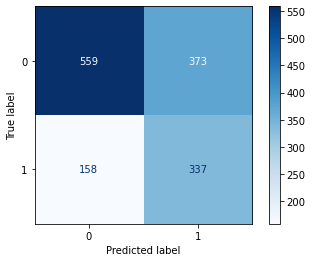

              precision    recall  f1-score   support

           0       0.78      0.60      0.68       932
           1       0.47      0.68      0.56       495

    accuracy                           0.63      1427
   macro avg       0.63      0.64      0.62      1427
weighted avg       0.67      0.63      0.64      1427

roc_auc_score:  0.6402967442667014


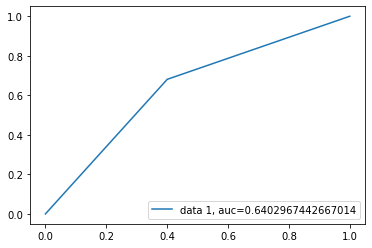

In [64]:
plot_conf_matrix (X_test_9, y_test_9, preds_9, final_cl_9)

plot_roc_curve(y_test_9, preds_9)

### Definição dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

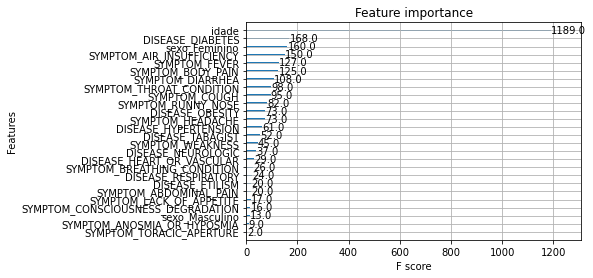

In [65]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_9)
plt.show()

### Teste com o Período 10 (22/11/2020 até 19/02/2021):

In [66]:
#Periodo 10
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=270)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=360)

df_10 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_10 = df_10.reset_index()
df_10 = df_10.drop("index", axis=1)
df_10

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.608696,1,0,2020-11-22
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.713043,1,0,2020-11-22
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.643478,1,0,2020-11-22
3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.469565,1,0,2020-11-22
4,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.304348,1,0,2020-11-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.660870,1,0,2021-02-19
2812,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.634783,1,0,2021-02-19
2813,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2021-02-19
2814,1,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0.460870,0,1,2021-02-19


In [67]:
X_train_oversampled_10, y_train_oversampled_10, X_test_10, y_test_10, mean_test_scores_10, std_test_scores_10, best_scores_10, best_params_10 = apply_model_xgboost(df_10)

########################################

best_score: 0.8687987174184151
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [68]:
preds_10, final_cl_10 = create_final_cl(X_train_oversampled_10, y_train_oversampled_10, X_test_10, y_test_10, 0.9, 0.25, 7, 5)

accuracy_score: 0.6410437235543018
########################################
"""Métricas f1_score:"""
f1:  0.5851670741646292
Macro:  0.6344107589592568
Micro:  0.6410437235543018
weighted:  0.6502465278353853
########################################
"""Métricas precision_score:"""
Precision:  0.4812332439678284
Macro:  0.6498428124601047
Micro:  0.6410437235543018
weighted:  0.7040642251769439


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


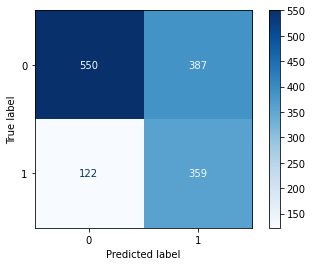

              precision    recall  f1-score   support

           0       0.82      0.59      0.68       937
           1       0.48      0.75      0.59       481

    accuracy                           0.64      1418
   macro avg       0.65      0.67      0.63      1418
weighted avg       0.70      0.64      0.65      1418

roc_auc_score:  0.6666707344402115


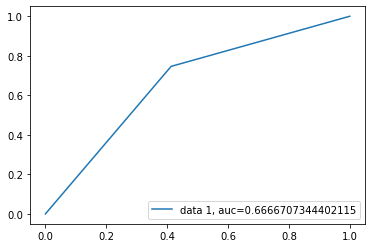

In [69]:
plot_conf_matrix (X_test_10, y_test_10, preds_10, final_cl_10)

plot_roc_curve(y_test_10, preds_10)

### Definição dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

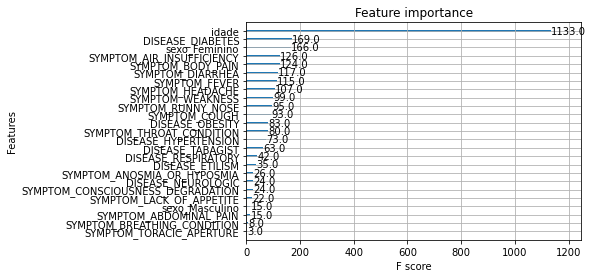

In [70]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_10)
plt.show()

### Teste com o Período 11 (22/12/2020 até 21/03/2021):

In [71]:
#Periodo 11
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=300)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=390)

df_11 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_11 = df_11.reset_index()
df_11 = df_11.drop("index", axis=1)
df_11

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.339130,1,0,2020-12-22
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.678261,1,0,2020-12-22
2,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0.782609,1,0,2020-12-22
3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.600000,1,0,2020-12-22
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0.591304,0,1,2020-12-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.765217,1,0,2021-03-21
3363,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.443478,0,1,2021-03-21
3364,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.582609,0,1,2021-03-21
3365,1,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0.400000,0,1,2021-03-21


In [72]:
X_train_oversampled_11, y_train_oversampled_11, X_test_11, y_test_11, mean_test_scores_11, std_test_scores_11, best_scores_11, best_params_11 = apply_model_xgboost(df_11)

########################################

best_score: 0.8447421233721595
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [73]:
preds_11, final_cl_11 = create_final_cl(X_train_oversampled_11, y_train_oversampled_11, X_test_11, y_test_11, 0.9, 0.25, 7, 5)

accuracy_score: 0.6556188503366132
########################################
"""Métricas f1_score:"""
f1:  0.5793801391524351
Macro:  0.6439206701899834
Micro:  0.6556188503366132
weighted:  0.6656124385190196
########################################
"""Métricas precision_score:"""
Precision:  0.48723404255319147
Macro:  0.6512860424673121
Micro:  0.6556188503366132
weighted:  0.7064231465295931


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


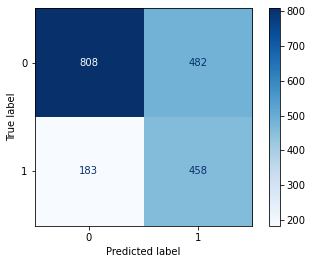

              precision    recall  f1-score   support

           0       0.82      0.63      0.71      1290
           1       0.49      0.71      0.58       641

    accuracy                           0.66      1931
   macro avg       0.65      0.67      0.64      1931
weighted avg       0.71      0.66      0.67      1931

roc_auc_score:  0.6704325847452504


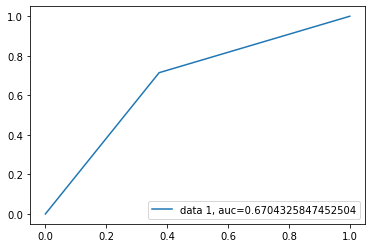

In [74]:
plot_conf_matrix (X_test_11, y_test_11, preds_11, final_cl_11)

plot_roc_curve(y_test_11, preds_11)

### Definição dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

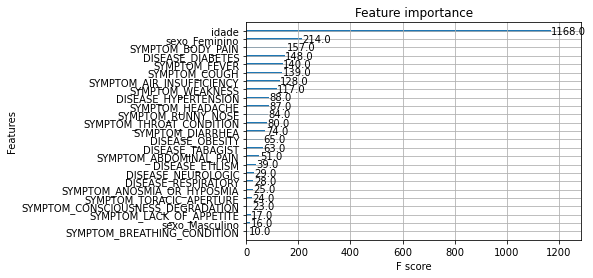

In [75]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_11)
plt.show()

### Teste com o Período 12 (21/01/2021 até 20/04/2021):

In [76]:
#Periodo 12
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=330)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=420)

df_12 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_12 = df_12.reset_index()
df_12 = df_12.drop("index", axis=1)
df_12

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.626087,1,0,2021-01-21
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.339130,0,1,2021-01-21
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.530435,0,1,2021-01-21
3,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.556522,0,1,2021-01-21
4,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.295652,1,0,2021-01-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4466,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.591304,0,1,2021-04-20
4467,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.478261,1,0,2021-04-20
4468,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2021-04-20
4469,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.765217,1,0,2021-04-20


In [77]:
X_train_oversampled_12, y_train_oversampled_12, X_test_12, y_test_12, mean_test_scores_12, std_test_scores_12, best_scores_12, best_params_12 = apply_model_xgboost(df_12)

########################################

best_score: 0.858719298245614
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [78]:
preds_12, final_cl_12 = create_final_cl(X_train_oversampled_12, y_train_oversampled_12, X_test_12, y_test_12, 0.9, 0.25, 7, 5)

accuracy_score: 0.6509628610729024
########################################
"""Métricas f1_score:"""
f1:  0.5534535855697317
Macro:  0.6334866008571209
Micro:  0.6509628610729024
weighted:  0.6614486172023711
########################################
"""Métricas precision_score:"""
Precision:  0.4740015071590053
Macro:  0.6367477491519251
Micro:  0.6509628610729024
weighted:  0.6936081968358339


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


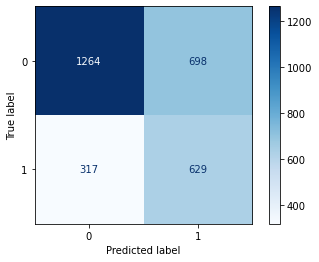

              precision    recall  f1-score   support

           0       0.80      0.64      0.71      1962
           1       0.47      0.66      0.55       946

    accuracy                           0.65      2908
   macro avg       0.64      0.65      0.63      2908
weighted avg       0.69      0.65      0.66      2908

roc_auc_score:  0.6545727167126782


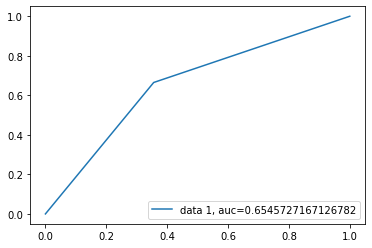

In [79]:
plot_conf_matrix (X_test_12, y_test_12, preds_12, final_cl_12)

plot_roc_curve(y_test_12, preds_12)

### Definição dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

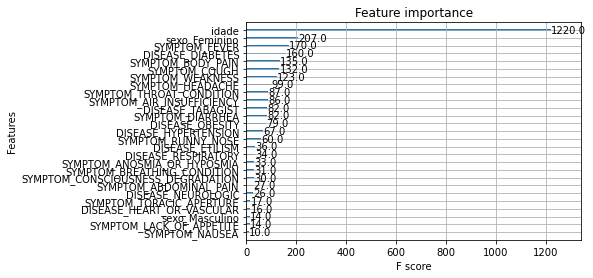

In [80]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_12)
plt.show()

### Teste com o Período 13 (20/02/2021 até 20/05/2021):

In [81]:
#Periodo 13
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=360)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=450)

df_13 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_13 = df_13.reset_index()
df_13 = df_13.drop("index", axis=1)
df_13

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.539130,1,0,2021-02-20
1,0,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,1,0.486957,0,1,2021-02-20
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.495652,1,0,2021-02-20
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.295652,1,0,2021-02-20
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.808696,0,1,2021-02-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5357,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0.191304,0,1,2021-05-20
5358,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.417391,1,0,2021-05-20
5359,1,0,1,1,0,0,0,1,0,1,...,0,0,0,0,0,1,0.547826,1,0,2021-05-20
5360,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0.756522,1,0,2021-05-20


In [82]:
X_train_oversampled_13, y_train_oversampled_13, X_test_13, y_test_13, mean_test_scores_13, std_test_scores_13, best_scores_13, best_params_13 = apply_model_xgboost(df_13)

########################################

best_score: 0.8610237544055043
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [83]:
preds_13, final_cl_13 = create_final_cl(X_train_oversampled_13, y_train_oversampled_13, X_test_13, y_test_13, 0.9, 0.25, 7, 5)

accuracy_score: 0.593040293040293
########################################
"""Métricas f1_score:"""
f1:  0.5353408615641991
Macro:  0.586666846552709
Micro:  0.593040293040293
weighted:  0.6054299722005232
########################################
"""Métricas precision_score:"""
Precision:  0.419672131147541
Macro:  0.6160601319638119
Micro:  0.593040293040293
weighted:  0.6878532546065367


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


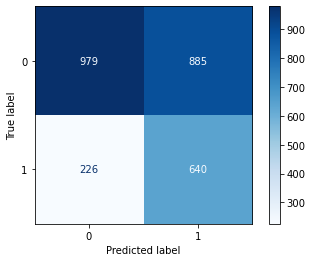

              precision    recall  f1-score   support

           0       0.81      0.53      0.64      1864
           1       0.42      0.74      0.54       866

    accuracy                           0.59      2730
   macro avg       0.62      0.63      0.59      2730
weighted avg       0.69      0.59      0.61      2730

roc_auc_score:  0.6321223076846831


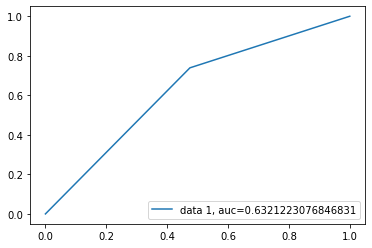

In [84]:
plot_conf_matrix (X_test_13, y_test_13, preds_13, final_cl_13)

plot_roc_curve(y_test_13, preds_13)

### Definição dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

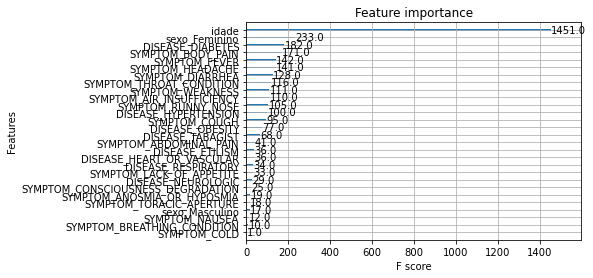

In [85]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_13)
plt.show()

### Teste com o Período 14 (22/03/2021 até 19/06/2021):

In [86]:
#Periodo 14
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=390)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=480)

df_14 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_14 = df_14.reset_index()
df_14 = df_14.drop("index", axis=1)
df_14

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,1,0,0,0,1,0,1,...,0,0,0,0,0,1,0.469565,0,1,2021-03-22
1,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.443478,1,0,2021-03-22
2,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0.417391,1,0,2021-03-22
3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.478261,1,0,2021-03-22
4,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.678261,0,1,2021-03-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5617,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0.478261,0,1,2021-06-19
5618,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2021-06-19
5619,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.504348,0,1,2021-06-19
5620,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.469565,1,0,2021-06-19


In [87]:
X_train_oversampled_14, y_train_oversampled_14, X_test_14, y_test_14, mean_test_scores_14, std_test_scores_14, best_scores_14, best_params_14 = apply_model_xgboost(df_14)

########################################

best_score: 0.8466546414379469
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [88]:
preds_14, final_cl_14 = create_final_cl(X_train_oversampled_14, y_train_oversampled_14, X_test_14, y_test_14, 0.9, 0.25, 7, 5)

accuracy_score: 0.5606582472254114
########################################
"""Métricas f1_score:"""
f1:  0.5055986218776917
Macro:  0.5551409087349891
Micro:  0.5606582472254114
weighted:  0.5763949858750697
########################################
"""Métricas precision_score:"""
Precision:  0.37246192893401014
Macro:  0.6095675122008527
Micro:  0.5606582472254114
weighted:  0.7112878944596092


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


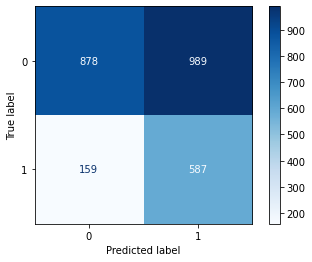

              precision    recall  f1-score   support

           0       0.85      0.47      0.60      1867
           1       0.37      0.79      0.51       746

    accuracy                           0.56      2613
   macro avg       0.61      0.63      0.56      2613
weighted avg       0.71      0.56      0.58      2613

roc_auc_score:  0.6285682181418197


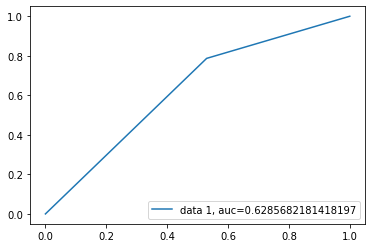

In [89]:
plot_conf_matrix (X_test_14, y_test_14, preds_14, final_cl_14)

plot_roc_curve(y_test_14, preds_14)

### Definição dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

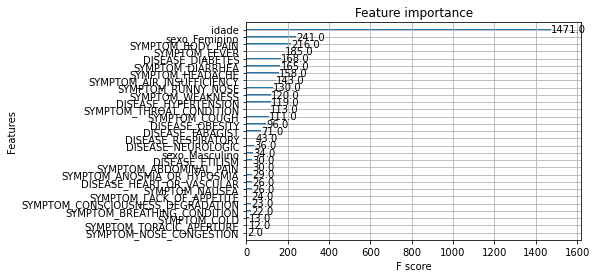

In [90]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_14)
plt.show()

### Teste com o Período 15 (21/04/2021 até 19/07/2021):

In [91]:
#Periodo 15
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=420)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=510)

df_15 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_15 = df_15.reset_index()
df_15 = df_15.drop("index", axis=1)
df_15

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2021-04-21
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.608696,0,1,2021-04-21
2,1,0,1,1,0,0,0,1,1,1,...,0,0,0,0,0,1,0.452174,0,1,2021-04-21
3,1,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0.504348,1,0,2021-04-21
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.643478,1,0,2021-04-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4719,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.547826,1,0,2021-07-19
4720,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.513043,1,0,2021-07-19
4721,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.243478,0,1,2021-07-19
4722,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.356522,0,1,2021-07-19


In [92]:
X_train_oversampled_15, y_train_oversampled_15, X_test_15, y_test_15, mean_test_scores_15, std_test_scores_15, best_scores_15, best_params_15 = apply_model_xgboost(df_15)

########################################

best_score: 0.871979511056631
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################



In [93]:
preds_15, final_cl_15 = create_final_cl(X_train_oversampled_15, y_train_oversampled_15, X_test_15, y_test_15, 0.9, 0.25, 7, 3)

accuracy_score: 0.6096911608093717
########################################
"""Métricas f1_score:"""
f1:  0.5016995241332426
Macro:  0.5904558889812821
Micro:  0.6096911608093717
weighted:  0.6288319104171757
########################################
"""Métricas precision_score:"""
Precision:  0.39339019189765456
Macro:  0.6094610533956357
Micro:  0.6096911608093717
weighted:  0.7028846633723987


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


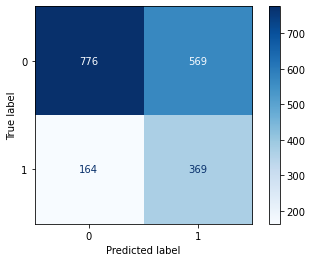

              precision    recall  f1-score   support

           0       0.83      0.58      0.68      1345
           1       0.39      0.69      0.50       533

    accuracy                           0.61      1878
   macro avg       0.61      0.63      0.59      1878
weighted avg       0.70      0.61      0.63      1878

roc_auc_score:  0.6346296825850729


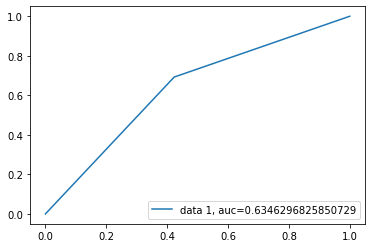

In [94]:
plot_conf_matrix (X_test_15, y_test_15, preds_15, final_cl_15)

plot_roc_curve(y_test_15, preds_15)

### Determinação dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

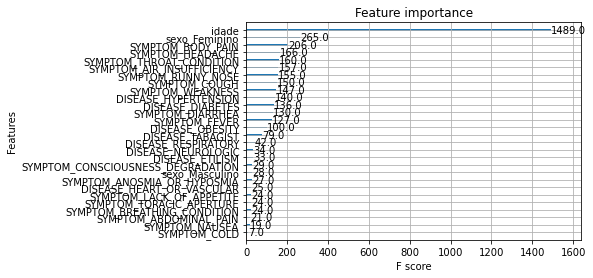

In [95]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_15)
plt.show()

### Teste com o Período 16 (21/05/2021 até 18/08/2021):

In [96]:
#Periodo 16
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=450)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=540)

df_16 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_16 = df_16.reset_index()
df_16 = df_16.drop("index", axis=1)
df_16

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.486957,0,1,2021-05-21
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.591304,1,0,2021-05-21
2,1,0,1,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0.295652,0,1,2021-05-21
3,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.347826,0,1,2021-05-21
4,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.504348,0,1,2021-05-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.617391,0,1,2021-08-18
3497,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.060870,0,1,2021-08-18
3498,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.556522,0,1,2021-08-18
3499,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.060870,0,1,2021-08-18


In [97]:
X_train_oversampled_16, y_train_oversampled_16, X_test_16, y_test_16, mean_test_scores_16, std_test_scores_16, best_scores_16, best_params_16 = apply_model_xgboost(df_16)

########################################

best_score: 0.8812618307193076
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [98]:
preds_16, final_cl_16 = create_final_cl(X_train_oversampled_16, y_train_oversampled_16, X_test_16, y_test_16, 0.9, 0.25, 7, 5)

accuracy_score: 0.6113615870153292
########################################
"""Métricas f1_score:"""
f1:  0.5685685685685685
Macro:  0.6075000348995426
Micro:  0.6113615870153292
weighted:  0.6197516866123559
########################################
"""Métricas precision_score:"""
Precision:  0.4588045234248788
Macro:  0.63144307803897
Micro:  0.6113615870153292
weighted:  0.6857720731339366


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


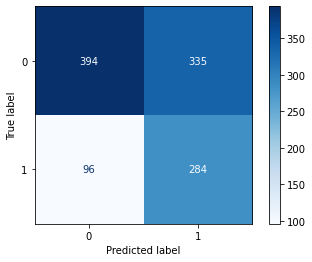

              precision    recall  f1-score   support

           0       0.80      0.54      0.65       729
           1       0.46      0.75      0.57       380

    accuracy                           0.61      1109
   macro avg       0.63      0.64      0.61      1109
weighted avg       0.69      0.61      0.62      1109

roc_auc_score:  0.643917406685438


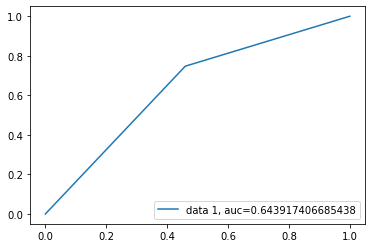

In [99]:
plot_conf_matrix (X_test_16, y_test_16, preds_16, final_cl_16)

plot_roc_curve(y_test_16, preds_16)

### Determinação dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

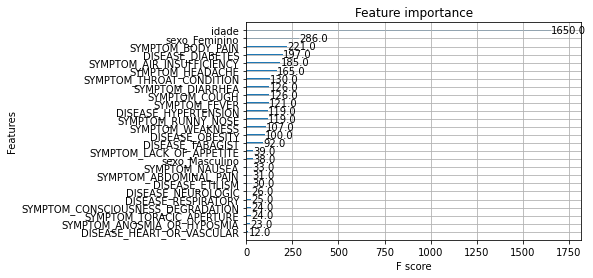

In [100]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_16)
plt.show()

### Teste com o Período 17 (20/06/2021 até 17/09/2021):

In [101]:
#Periodo 17
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=480)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=570)

df_17 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_17 = df_17.reset_index()
df_17 = df_17.drop("index", axis=1)
df_17

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0.486957,1,0,2021-06-20
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.426087,1,0,2021-06-20
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.617391,0,1,2021-06-20
3,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,1,0.591304,0,1,2021-06-20
4,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0.321739,1,0,2021-06-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2309,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0.356522,1,0,2021-09-17
2310,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.365217,0,1,2021-09-17
2311,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.052174,0,1,2021-09-17
2312,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.356522,0,1,2021-09-17


In [102]:
X_train_oversampled_17, y_train_oversampled_17, X_test_17, y_test_17, mean_test_scores_17, std_test_scores_17, best_scores_17, best_params_17 = apply_model_xgboost(df_17)

########################################

best_score: 0.8798768107009117
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [103]:
preds_17, final_cl_17 = create_final_cl(X_train_oversampled_17, y_train_oversampled_17, X_test_17, y_test_17, 0.9, 0.25, 7, 5)

accuracy_score: 0.6136363636363636
########################################
"""Métricas f1_score:"""
f1:  0.5405405405405407
Macro:  0.6036036036036037
Micro:  0.6136363636363636
weighted:  0.6284466284466286
########################################
"""Métricas precision_score:"""
Precision:  0.4225352112676056
Macro:  0.6293003925190488
Micro:  0.6136363636363636
weighted:  0.7107533427090112


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


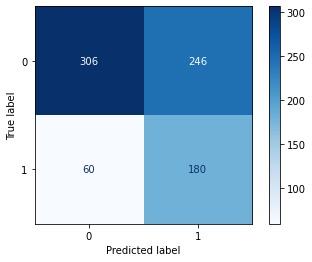

              precision    recall  f1-score   support

           0       0.84      0.55      0.67       552
           1       0.42      0.75      0.54       240

    accuracy                           0.61       792
   macro avg       0.63      0.65      0.60       792
weighted avg       0.71      0.61      0.63       792

roc_auc_score:  0.6521739130434783


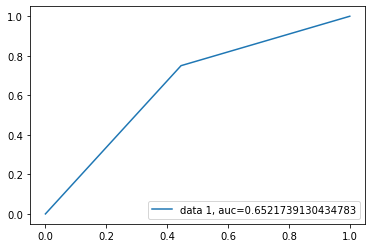

In [104]:
plot_conf_matrix (X_test_17, y_test_17, preds_17, final_cl_17)

plot_roc_curve(y_test_17, preds_17)

### Determinação dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

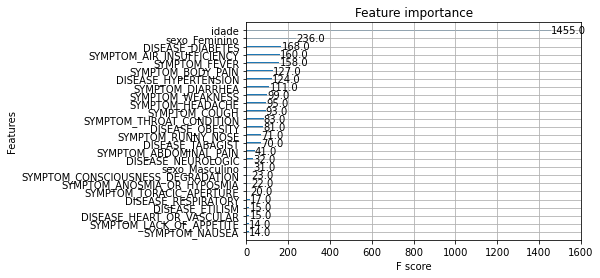

In [105]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_17)
plt.show()

### Teste com o Período 18 (20/07/2021 até 17/10/2021):

In [106]:
#Periodo 18
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=510)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=600)

df_18 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_18 = df_18.reset_index()
df_18 = df_18.drop("index", axis=1)
df_18

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0.608696,0,1,2021-07-20
1,1,0,1,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0.504348,1,0,2021-07-20
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.504348,1,0,2021-07-20
3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.600000,1,0,2021-07-20
4,1,0,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0.521739,1,0,2021-07-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2021-10-17
1754,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.704348,0,1,2021-10-17
1755,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.704348,0,1,2021-10-17
1756,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.591304,0,1,2021-10-17


In [107]:
X_train_oversampled_18, y_train_oversampled_18, X_test_18, y_test_18, mean_test_scores_18, std_test_scores_18, best_scores_18, best_params_18 = apply_model_xgboost(df_18)

########################################

best_score: 0.8840799382238623
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [108]:
preds_18, final_cl_18 = create_final_cl(X_train_oversampled_18, y_train_oversampled_18, X_test_18, y_test_18, 0.9, 0.25, 7, 5)

accuracy_score: 0.5802325581395349
########################################
"""Métricas f1_score:"""
f1:  0.4993065187239945
Macro:  0.5689725786813166
Micro:  0.5802325581395349
weighted:  0.6012133831731935
########################################
"""Métricas precision_score:"""
Precision:  0.3673469387755102
Macro:  0.6147545504688362
Micro:  0.5802325581395349
weighted:  0.7292524916943521


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


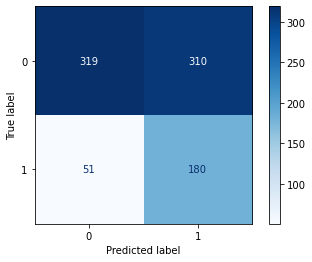

              precision    recall  f1-score   support

           0       0.86      0.51      0.64       629
           1       0.37      0.78      0.50       231

    accuracy                           0.58       860
   macro avg       0.61      0.64      0.57       860
weighted avg       0.73      0.58      0.60       860

roc_auc_score:  0.6431874961286727


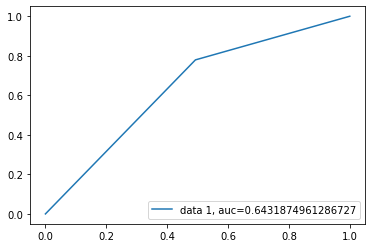

In [109]:
plot_conf_matrix (X_test_18, y_test_18, preds_18, final_cl_18)

plot_roc_curve(y_test_18, preds_18)

### Determinação dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

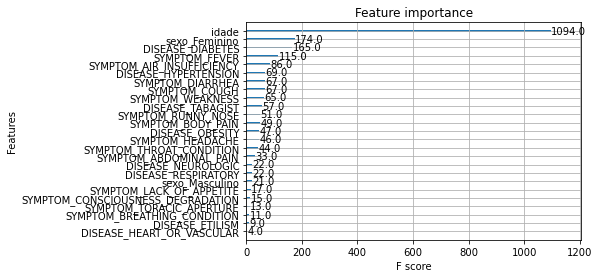

In [110]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_18)
plt.show()

### Teste com o Período 19 (19/08/2021 até 16/11/2021):

In [111]:
#Periodo 19
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=540)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=630)

df_19 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_19 = df_19.reset_index()
df_19 = df_19.drop("index", axis=1)
df_19

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0.582609,0,1,2021-08-19
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.634783,1,0,2021-08-19
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.739130,1,0,2021-08-19
3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.008696,1,0,2021-08-19
4,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.373913,0,1,2021-08-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0.182609,0,1,2021-11-16
1609,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.695652,1,0,2021-11-16
1610,0,0,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0.486957,1,0,2021-11-16
1611,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.478261,0,1,2021-11-16


In [112]:
X_train_oversampled_19, y_train_oversampled_19, X_test_19, y_test_19, mean_test_scores_19, std_test_scores_19, best_scores_19, best_params_19 = apply_model_xgboost(df_19)

########################################

best_score: 0.90819091796875
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################



In [113]:
preds_19, final_cl_19 = create_final_cl(X_train_oversampled_19, y_train_oversampled_19, X_test_19, y_test_19, 0.9, 0.25, 7, 3)

accuracy_score: 0.6276150627615062
########################################
"""Métricas f1_score:"""
f1:  0.38337182448036955
Macro:  0.5583192788735514
Micro:  0.6276150627615062
weighted:  0.6546989782951789
########################################
"""Métricas precision_score:"""
Precision:  0.30514705882352944
Macro:  0.5649330799735625
Micro:  0.6276150627615062
weighted:  0.7080509019460353


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


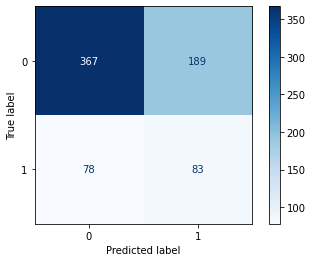

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       556
           1       0.31      0.52      0.38       161

    accuracy                           0.63       717
   macro avg       0.56      0.59      0.56       717
weighted avg       0.71      0.63      0.65       717

roc_auc_score:  0.5877999463783011


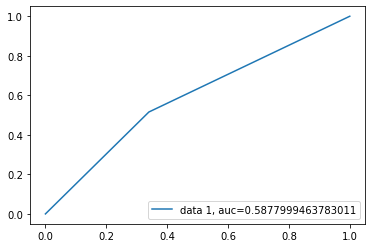

In [114]:
plot_conf_matrix (X_test_19, y_test_19, preds_19, final_cl_19)

plot_roc_curve(y_test_19, preds_19)

### Determinação dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

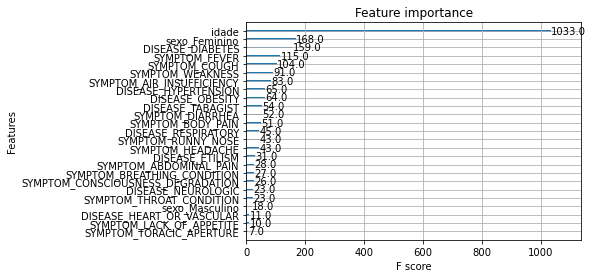

In [115]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_19)
plt.show()

### Teste com o Período 20 (18/09/2021 até 16/12/2021):

In [116]:
#Periodo 20
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=570)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=660)

df_20 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_20 = df_20.reset_index()
df_20 = df_20.drop("index", axis=1)
df_20

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.591304,1,0,2021-09-18
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.043478,1,0,2021-09-18
2,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.121739,0,1,2021-09-18
3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.565217,0,1,2021-09-18
4,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.573913,1,0,2021-09-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.408696,1,0,2021-12-16
1570,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.434783,1,0,2021-12-16
1571,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.773913,1,0,2021-12-16
1572,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.747826,1,0,2021-12-16


In [117]:
X_train_oversampled_20, y_train_oversampled_20, X_test_20, y_test_20, mean_test_scores_20, std_test_scores_20, best_scores_20, best_params_20 = apply_model_xgboost(df_20)

########################################

best_score: 0.9131881106371267
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [118]:
preds_20, final_cl_20 = create_final_cl(X_train_oversampled_20, y_train_oversampled_20, X_test_20, y_test_20, 0.9, 0.25, 7, 5)

accuracy_score: 0.6159217877094972
########################################
"""Métricas f1_score:"""
f1:  0.346793349168646
Macro:  0.5373927181055891
Micro:  0.6159217877094972
weighted:  0.6486644167307877
########################################
"""Métricas precision_score:"""
Precision:  0.26838235294117646
Macro:  0.5486055908850026
Micro:  0.6159217877094972
weighted:  0.7121996040980185


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


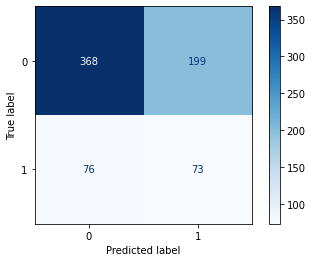

              precision    recall  f1-score   support

           0       0.83      0.65      0.73       567
           1       0.27      0.49      0.35       149

    accuracy                           0.62       716
   macro avg       0.55      0.57      0.54       716
weighted avg       0.71      0.62      0.65       716

roc_auc_score:  0.569481434134678


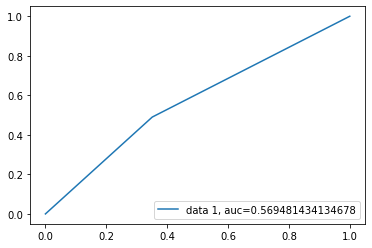

In [119]:
plot_conf_matrix (X_test_20, y_test_20, preds_20, final_cl_20)

plot_roc_curve(y_test_20, preds_20)

### Determinação dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

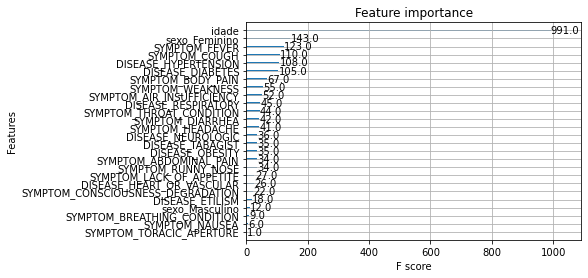

In [120]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_20)
plt.show()

### Teste com o Período 21 (18/10/2021 até 15/01/2022):

In [121]:
#Periodo 21
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=600)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=690)

df_21 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_21 = df_21.reset_index()
df_21 = df_21.drop("index", axis=1)
df_21

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.008696,0,1,2021-10-18
1,1,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0.791304,1,0,2021-10-18
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.313043,0,1,2021-10-18
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.739130,1,0,2021-10-18
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.521739,0,1,2021-10-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,1,0,1,1,0,0,0,0,0,0,...,0,1,1,0,0,1,0.382609,0,1,2022-01-15
2235,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.695652,0,1,2022-01-15
2236,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0.304348,0,1,2022-01-15
2237,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0.643478,0,1,2022-01-15


In [122]:
X_train_oversampled_21, y_train_oversampled_21, X_test_21, y_test_21, mean_test_scores_21, std_test_scores_21, best_scores_21, best_params_21 = apply_model_xgboost(df_21)

########################################

best_score: 0.9425074401664932
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [123]:
preds_21, final_cl_21 = create_final_cl(X_train_oversampled_21, y_train_oversampled_21, X_test_21, y_test_21, 0.9, 0.25, 7, 5)

accuracy_score: 0.6132785763175906
########################################
"""Métricas f1_score:"""
f1:  0.3168077388149939
Macro:  0.5235590006724133
Micro:  0.6132785763175906
weighted:  0.6337980376244529
########################################
"""Métricas precision_score:"""
Precision:  0.26954732510288065
Macro:  0.5270813548591327
Micro:  0.6132785763175906
weighted:  0.6643975829084963


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


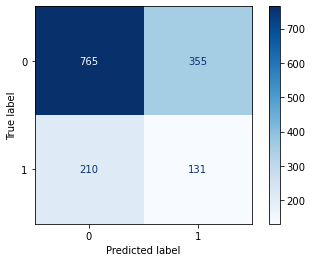

              precision    recall  f1-score   support

           0       0.78      0.68      0.73      1120
           1       0.27      0.38      0.32       341

    accuracy                           0.61      1461
   macro avg       0.53      0.53      0.52      1461
weighted avg       0.66      0.61      0.63      1461

roc_auc_score:  0.5335999685798074


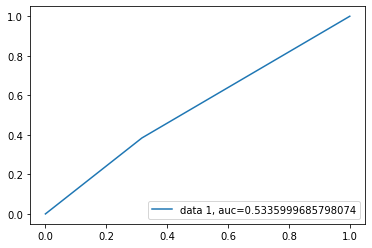

In [124]:
plot_conf_matrix (X_test_21, y_test_21, preds_21, final_cl_21)

plot_roc_curve(y_test_21, preds_21)

### Determinação dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

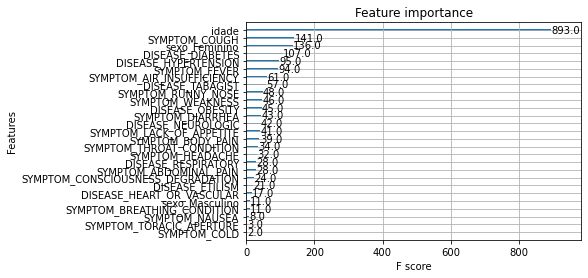

In [125]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_21)
plt.show()

### Teste com o Período 22 (17/11/2021 até 14/02/2022):

In [126]:
#Periodo 22
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=630)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=720)

df_22 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_22 = df_22.reset_index()
df_22 = df_22.drop("index", axis=1)
df_22

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.617391,1,0,2021-11-17
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.521739,1,0,2021-11-17
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.556522,1,0,2021-11-17
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.695652,1,0,2021-11-17
4,1,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0.626087,0,1,2021-11-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2780,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0.678261,1,0,2022-02-14
2781,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.626087,1,0,2022-02-14
2782,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.556522,1,0,2022-02-14
2783,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.539130,1,0,2022-02-14


In [127]:
X_train_oversampled_22, y_train_oversampled_22, X_test_22, y_test_22, mean_test_scores_22, std_test_scores_22, best_scores_22, best_params_22 = apply_model_xgboost(df_22)

########################################

best_score: 0.9053036372376223
best_params_: {'colsample_bytree': 0.9, 'gamma': 1, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [128]:
preds_22, final_cl_22 = create_final_cl(X_train_oversampled_22, y_train_oversampled_22, X_test_22, y_test_22, 0.9, 1, 7, 5)

accuracy_score: 0.557395773843518
########################################
"""Métricas f1_score:"""
f1:  0.3642329778506973
Macro:  0.5123836812161942
Micro:  0.557395773843518
weighted:  0.5882781306273025
########################################
"""Métricas precision_score:"""
Precision:  0.2803030303030303
Macro:  0.5332693462255507
Micro:  0.557395773843518
weighted:  0.6628586011555911


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


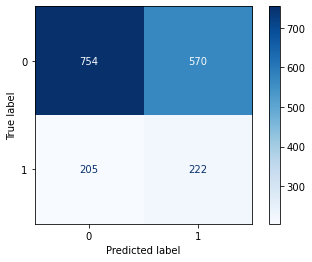

              precision    recall  f1-score   support

           0       0.79      0.57      0.66      1324
           1       0.28      0.52      0.36       427

    accuracy                           0.56      1751
   macro avg       0.53      0.54      0.51      1751
weighted avg       0.66      0.56      0.59      1751

roc_auc_score:  0.5446963640094242


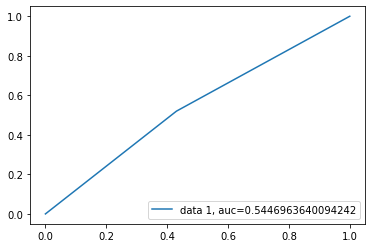

In [129]:
plot_conf_matrix (X_test_22, y_test_22, preds_22, final_cl_22)

plot_roc_curve(y_test_22, preds_22)

### Determinação dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

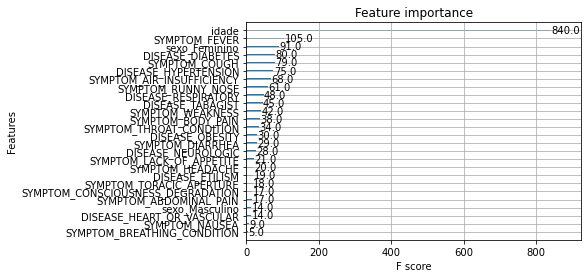

In [130]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_22)
plt.show()

### Teste com o Período 23 (17/12/2021 até 16/03/2022):

In [131]:
#Periodo 23
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=660)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=750)

df_23 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_23 = df_23.reset_index()
df_23 = df_23.drop("index", axis=1)
df_23

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0.330435,0,1,2021-12-17
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.800000,0,1,2021-12-17
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.295652,0,1,2021-12-17
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.643478,1,0,2021-12-17
4,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.365217,0,1,2021-12-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.504348,0,1,2022-03-16
2809,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.017391,0,1,2022-03-16
2810,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.643478,1,0,2022-03-16
2811,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2022-03-16


In [132]:
X_train_oversampled_23, y_train_oversampled_23, X_test_23, y_test_23, mean_test_scores_23, std_test_scores_23, best_scores_23, best_params_23 = apply_model_xgboost(df_23)

########################################

best_score: 0.8713623528158132
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [133]:
preds_23, final_cl_23 = create_final_cl(X_train_oversampled_23, y_train_oversampled_23, X_test_23, y_test_23, 0.9, 0.25, 7, 5)

accuracy_score: 0.5069033530571992
########################################
"""Métricas f1_score:"""
f1:  0.42263279445727486
Macro:  0.4961700977449886
Micro:  0.5069033530571992
weighted:  0.5243086319418653
########################################
"""Métricas precision_score:"""
Precision:  0.3309222423146474
Macro:  0.5244632903547206
Micro:  0.5069033530571992
weighted:  0.5985204172181807


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


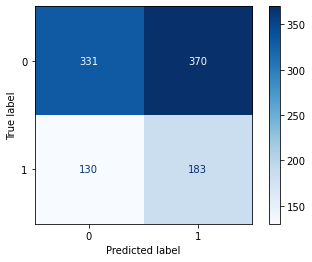

              precision    recall  f1-score   support

           0       0.72      0.47      0.57       701
           1       0.33      0.58      0.42       313

    accuracy                           0.51      1014
   macro avg       0.52      0.53      0.50      1014
weighted avg       0.60      0.51      0.52      1014

roc_auc_score:  0.5284235665161136


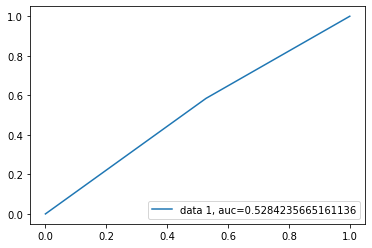

In [134]:
plot_conf_matrix (X_test_23, y_test_23, preds_23, final_cl_23)

plot_roc_curve(y_test_23, preds_23)

### Determinação dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

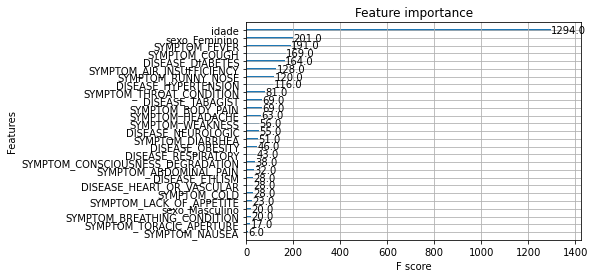

In [135]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_23)
plt.show()

### Teste com o Período 24 (16/01/2022 até 15/04/2022):

In [136]:
#Periodo 24
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=690)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=780)

df_24 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_24 = df_24.reset_index()
df_24 = df_24.drop("index", axis=1)
df_24

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.495652,0,1,2022-01-16
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.573913,0,1,2022-01-16
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0.460870,1,0,2022-01-16
3,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0.669565,1,0,2022-01-16
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.721739,0,1,2022-01-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0.739130,1,0,2022-04-15
2068,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.530435,0,1,2022-04-15
2069,1,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0.695652,0,1,2022-04-15
2070,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.686957,1,0,2022-04-15


In [137]:
X_train_oversampled_24, y_train_oversampled_24, X_test_24, y_test_24, mean_test_scores_24, std_test_scores_24, best_scores_24, best_params_24 = apply_model_xgboost(df_24)

########################################

best_score: 0.8669682583884756
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################



In [138]:
preds_24, final_cl_24 = create_final_cl(X_train_oversampled_24, y_train_oversampled_24, X_test_24, y_test_24, 0.9, 0.25, 7, 3)

accuracy_score: 0.6166883963494133
########################################
"""Métricas f1_score:"""
f1:  0.5273311897106109
Macro:  0.6024813843289897
Micro:  0.6166883963494133
weighted:  0.6206075720791854
########################################
"""Métricas precision_score:"""
Precision:  0.4954682779456193
Macro:  0.6020919371379473
Micro:  0.6166883963494133
weighted:  0.6278095081295779


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


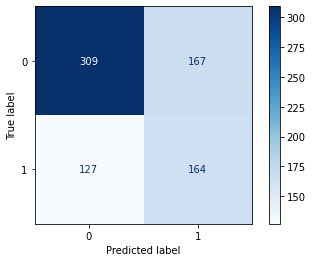

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       476
           1       0.50      0.56      0.53       291

    accuracy                           0.62       767
   macro avg       0.60      0.61      0.60       767
weighted avg       0.63      0.62      0.62       767

roc_auc_score:  0.6063667735135291


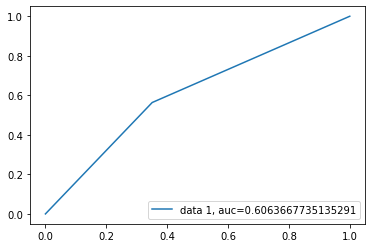

In [139]:
plot_conf_matrix (X_test_24, y_test_24, preds_24, final_cl_24)

plot_roc_curve(y_test_24, preds_24)

### Determinação dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

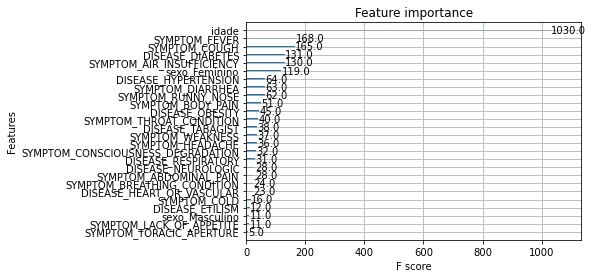

In [140]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_24)
plt.show()

### Teste com o Período 25 (15/02/2022 até 15/05/2021):

In [141]:
#Periodo 25
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=720)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=810)

df_25 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_25 = df_25.reset_index()
df_25 = df_25.drop("index", axis=1)
df_25

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.373913,1,0,2022-02-15
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.582609,0,1,2022-02-15
2,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.686957,0,1,2022-02-15
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.626087,0,1,2022-02-15
4,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.313043,0,1,2022-02-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.008696,1,0,2022-05-15
1479,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.043478,1,0,2022-05-15
1480,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.026087,1,0,2022-05-15
1481,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.356522,0,1,2022-05-15


In [142]:
X_train_oversampled_25, y_train_oversampled_25, X_test_25, y_test_25, mean_test_scores_25, std_test_scores_25, best_scores_25, best_params_25 = apply_model_xgboost(df_25)

########################################

best_score: 0.8122053357401423
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [143]:
preds_25, final_cl_25 = create_final_cl(X_train_oversampled_25, y_train_oversampled_25, X_test_25, y_test_25, 0.9, 0.25, 7, 5)

accuracy_score: 0.6713836477987422
########################################
"""Métricas f1_score:"""
f1:  0.5543710021321961
Macro:  0.6470485147647282
Micro:  0.6713836477987422
weighted:  0.685226986949828
########################################
"""Métricas precision_score:"""
Precision:  0.46099290780141844
Macro:  0.6499879793244381
Micro:  0.6713836477987422
weighted:  0.7278444396059335


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


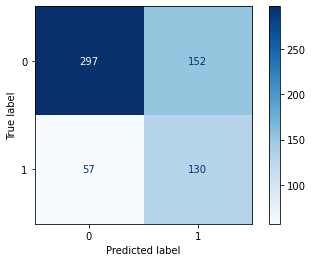

              precision    recall  f1-score   support

           0       0.84      0.66      0.74       449
           1       0.46      0.70      0.55       187

    accuracy                           0.67       636
   macro avg       0.65      0.68      0.65       636
weighted avg       0.73      0.67      0.69       636

roc_auc_score:  0.6783285494801282


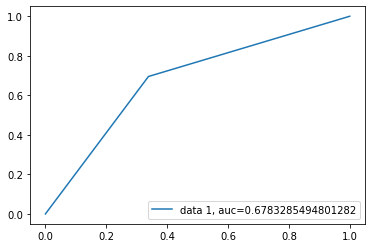

In [144]:
plot_conf_matrix (X_test_25, y_test_25, preds_25, final_cl_25)

plot_roc_curve(y_test_25, preds_25)

### Determinação dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

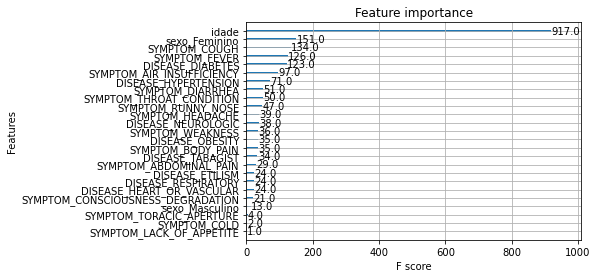

In [145]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_25)
plt.show()

### Teste com o Período 26 (17/03/2022 até 13/06/2022):

In [146]:
#Periodo 26
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=750)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=840)

df_26 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_26 = df_26.reset_index()
df_26 = df_26.drop("index", axis=1)
df_26

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0.582609,0,1,2022-03-17
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.513043,0,1,2022-03-17
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0.678261,1,0,2022-03-17
3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.530435,1,0,2022-03-17
4,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0.426087,0,1,2022-03-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2022-06-12
1391,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.556522,0,1,2022-06-12
1392,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.573913,1,0,2022-06-12
1393,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2022-06-13


In [147]:
X_train_oversampled_26, y_train_oversampled_26, X_test_26, y_test_26, mean_test_scores_26, std_test_scores_26, best_scores_26, best_params_26 = apply_model_xgboost(df_26)

########################################

best_score: 0.8518672143470789
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################



In [148]:
preds_26, final_cl_26 = create_final_cl(X_train_oversampled_26, y_train_oversampled_26, X_test_26, y_test_26, 0.9, 0.25, 7, 5)

accuracy_score: 0.6945337620578779
########################################
"""Métricas f1_score:"""
f1:  0.3356643356643356
Macro:  0.5686672409010614
Micro:  0.6945337620578779
weighted:  0.7552194061870571
########################################
"""Métricas precision_score:"""
Precision:  0.21428571428571427
Macro:  0.5895549174443646
Micro:  0.6945337620578779
weighted:  0.8900116106485575


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


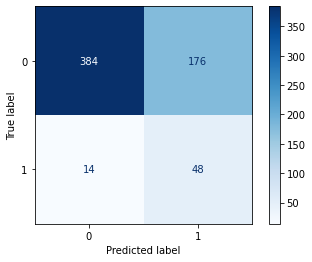

              precision    recall  f1-score   support

           0       0.96      0.69      0.80       560
           1       0.21      0.77      0.34        62

    accuracy                           0.69       622
   macro avg       0.59      0.73      0.57       622
weighted avg       0.89      0.69      0.76       622

roc_auc_score:  0.7299539170506912


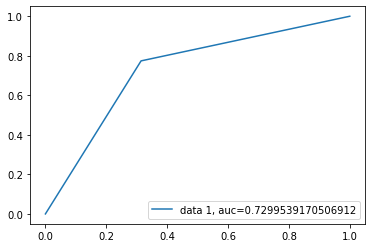

In [150]:
plot_conf_matrix (X_test_26, y_test_26, preds_26, final_cl_26)

plot_roc_curve(y_test_26, preds_26)

### Determinação dos atributos mais importantes:

<Figure size 720x720 with 0 Axes>

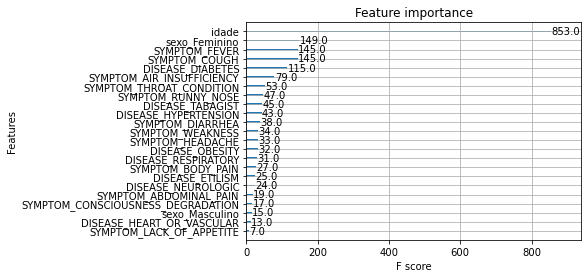

In [151]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_26)
plt.show()